In [2]:
%load_ext autoreload
%autoreload 2

import os
from functools import reduce

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
from sklearn.preprocessing import MinMaxScaler
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter

sns.set(rc={'figure.figsize':(12, 6)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})
pd.set_option('mode.chained_assignment', None)
from src.data.utils import save_to_csv, parallelize_dataframe

In [3]:
dir_path = "/scratch/czestoch/emoji-measures/september-dlab-stream"
context_free = pd.read_csv(os.path.join("/scratch/czestoch/emoji-measures/", "ambiguity_variation.csv.gz"))[["variation", "emoji"]]
context_vars = pd.read_csv(os.path.join(dir_path, "context_embedds_var_september.csv.gz"))\
    .rename({"tweet": "context_var", "emojis": "emoji"}, axis=1)
unguessability = pd.read_csv(os.path.join(dir_path, "mean_softmax_entropy_september.csv.gz"))\
    .rename({"tweet": "unguessability", "emojis": "emoji"}, axis=1)

In [4]:
display(context_free.head())
display(context_vars.head())
display(unguessability.head())

variation emoji
0   0.496355   #Ô∏è‚É£
1   0.584016   *Ô∏è‚É£
2   0.276658    ¬©Ô∏è
3   0.576165    ¬ÆÔ∏è
4   0.494922    ‚ÄºÔ∏è

emoji  context_var
0    ¬©Ô∏è     2.247854
1    ‚ÄºÔ∏è     1.441939
2    ‚ÅâÔ∏è     1.474284
3    ‚Ñ¢Ô∏è     2.054211
4     ‚åö     1.503281

emoji  unguessability
0    ¬©Ô∏è        3.910159
1    ‚ÄºÔ∏è        3.758624
2    ‚ÅâÔ∏è        3.501725
3    ‚Ñ¢Ô∏è        4.224252
4     ‚åö        4.015975

In [5]:
len(context_free), len(context_vars), len(unguessability)

(1325, 547, 547)

In [6]:
dfs = [context_free, context_vars, unguessability]
measures = reduce(lambda left, right: pd.merge(left, right, on='emoji'), dfs)
measures.head()

variation emoji  context_var  unguessability
0   0.276658    ¬©Ô∏è     2.247854        3.910159
1   0.494922    ‚ÄºÔ∏è     1.441939        3.758624
2   0.487782    ‚ÅâÔ∏è     1.474284        3.501725
3   0.272759    ‚Ñ¢Ô∏è     2.054211        4.224252
4   0.093595     ‚åö     1.503281        4.015975

In [7]:
measures.describe()

variation  context_var  unguessability
count  547.000000   547.000000      547.000000
mean     0.239422     1.642121        3.677143
std      0.159453     0.252542        0.475729
min      0.000000     1.057340        2.124642
25%      0.109064     1.464315        3.384115
50%      0.227645     1.615021        3.671025
75%      0.347845     1.800898        3.961978
max      0.713159     2.738338        5.754935

In [8]:
measures[measures.isna().any(axis=1)]

Empty DataFrame
Columns: [variation, emoji, context_var, unguessability]
Index: []

In [9]:
len(measures)

547

In [10]:
context_free.describe()

variation
count  1325.000000
mean      0.262528
std       0.164641
min       0.000000
25%       0.128927
50%       0.247732
75%       0.383371
max       0.745275

In [11]:
context_vars.context_var = MinMaxScaler().fit_transform(context_vars.context_var.values.reshape(-1, 1))
unguessability.unguessability = MinMaxScaler().fit_transform(unguessability.unguessability.values.reshape(-1, 1))

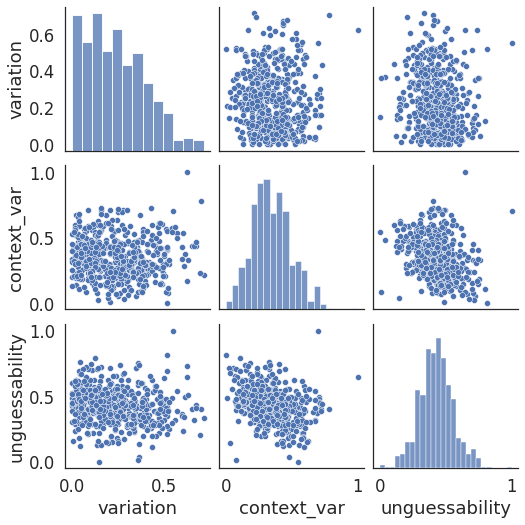

In [12]:
dfs = [context_free, context_vars, unguessability]
measures = reduce(lambda left, right: pd.merge(left, right, on='emoji'), dfs)
sns.pairplot(measures)

In [13]:
from settings import EMOJI_CATEGORIZED
import pickle

with open(EMOJI_CATEGORIZED, "rb") as f:
    categorized = pickle.load(f)

def assign_category(emoji):
    for category in categorized:
        if emoji in categorized[category]:
            return category

measures["category"] = measures.emoji.apply(assign_category)

In [14]:
flags = ['üè≥Ô∏è\u200düåà',
 'üè¥\u200d‚ò†Ô∏è',
 'üè¥\U000e0067\U000e0062\U000e0065\U000e006e\U000e0067\U000e007f',
 'üè¥\U000e0067\U000e0062\U000e0073\U000e0063\U000e0074\U000e007f',
 'üè¥\U000e0067\U000e0062\U000e0077\U000e006c\U000e0073\U000e007f']

measures = measures[~measures.emoji.isin(flags)]
measures[measures.category == 'flags']

Empty DataFrame
Columns: [variation, emoji, context_var, unguessability, category]
Index: []

In [15]:
display(context_free.nlargest(n=10, columns='variation'))
display(context_vars.nlargest(n=10, columns='context_var'))
display(unguessability.nlargest(n=10, columns='unguessability'))

variation emoji
1036   0.745275     üõÉ
1035   0.716157     üõÇ
652    0.713159     üíÅ
768    0.702734     üìµ
663    0.700732     üíå
1304   0.698550     üßª
1260   0.694345     üßê
155    0.692479     ‚ûø
105    0.692086     ‚õé
617    0.689072   üë©‚Äçüíº

emoji  context_var
353     üîû     1.000000
285     üíå     0.779643
314     üí¨     0.728202
202     üêá     0.724937
324     üìå     0.720812
251     üëâ     0.713203
11     ‚òéÔ∏è     0.711905
140     üç∞     0.709873
0      ¬©Ô∏è     0.708219
165     üéß     0.707000

emoji  unguessability
18         ‚ò¢Ô∏è        1.000000
325         üìç        0.815406
522         ü¶Ä        0.796155
118         üçå        0.758384
22          ‚ôà        0.754810
209         üêê        0.743477
159         üéä        0.740755
265  üë©‚Äç‚ù§Ô∏è‚Äçüíã‚Äçüë©        0.740206
174         üé±        0.735133
138         üç≠        0.725602

In [16]:
display(context_free.nsmallest(n=10, columns='variation'))
display(context_vars.nsmallest(n=10, columns='context_var'))
display(unguessability.nsmallest(n=10, columns='unguessability'))

variation    emoji
209        0.0        üåà
277        0.0        üçé
326        0.0        üçø
448        0.0        üêÑ
474        0.0        üêù
492        0.0        üêØ
533        0.0        üëó
573        0.0    üë®‚Äçüë©‚Äçüë¶
575        0.0    üë®‚Äçüë©‚Äçüëß
576        0.0  üë®‚Äçüë©‚Äçüëß‚Äçüë¶

emoji  context_var
325     üìç     0.000000
154     üéÇ     0.008689
498     ü§¥     0.023358
532     ü¶ç     0.032658
350     üîô     0.034003
123     üçí     0.049199
67     üÖ±Ô∏è     0.053577
517     ü•≥     0.062484
158     üéâ     0.067244
384     üòç     0.069922

emoji  unguessability
249     üëá        0.000000
253     üëã        0.012052
15     ‚òòÔ∏è        0.039638
455     üö®        0.109904
63     ‚¨áÔ∏è        0.119649
55      ‚ùì        0.127225
19     ‚òÆÔ∏è        0.130324
241     üêæ        0.132061
350     üîô        0.145339
469     ü§î        0.145692

In [17]:
display(unguessability.nsmallest(n=20, columns='unguessability'))

emoji  unguessability
249     üëá        0.000000
253     üëã        0.012052
15     ‚òòÔ∏è        0.039638
455     üö®        0.109904
63     ‚¨áÔ∏è        0.119649
55      ‚ùì        0.127225
19     ‚òÆÔ∏è        0.130324
241     üêæ        0.132061
350     üîô        0.145339
469     ü§î        0.145692
459     üö≤        0.151559
189     üèê        0.154207
79      üåç        0.154744
28     ‚ôªÔ∏è        0.158599
205     üêä        0.159189
333     üì©        0.176840
61     ‚§µÔ∏è        0.179174
327     üìö        0.184865
80      üåé        0.185582
166     üé®        0.194142

In [18]:
context_free[context_free.emoji == '‚ÜòÔ∏è'].emoji

12    ‚ÜòÔ∏è
Name: emoji, dtype: object

In [19]:
context_free[context_free.emoji == '‚ÜóÔ∏è']

variation emoji
11    0.41467    ‚ÜóÔ∏è

In [26]:
dff = measures[['emoji', 'variation', 'context_var', 'unguessability', 'category']]
dff = dff.rename({"variation": "context_free_ambiguity"}, axis=1)
dff = dff.reset_index(drop=True)
dff

emoji  context_free_ambiguity  context_var  unguessability category
0      ¬©Ô∏è                0.276658     0.708219        0.491838  symbols
1      ‚ÄºÔ∏è                0.494922     0.228792        0.450096  symbols
2      ‚ÅâÔ∏è                0.487782     0.248033        0.379331  symbols
3      ‚Ñ¢Ô∏è                0.272759     0.593024        0.578358  symbols
4       ‚åö                0.093595     0.265284        0.520986  objects
..    ...                     ...          ...             ...      ...
537     üß¨                0.129710     0.424507        0.430411  objects
538     üß±                0.073671     0.421342        0.485465  objects
539     üß∏                0.197647     0.608683        0.306835  objects
540     üßπ                0.230861     0.470045        0.488601  objects
541     üßø                0.332203     0.387189        0.357507  objects

[542 rows x 5 columns]

In [18]:
# from src.visualization.emoji_plotting import get_emoji
# get_emoji('‚ÜóÔ∏è', log=True, cluster=True)

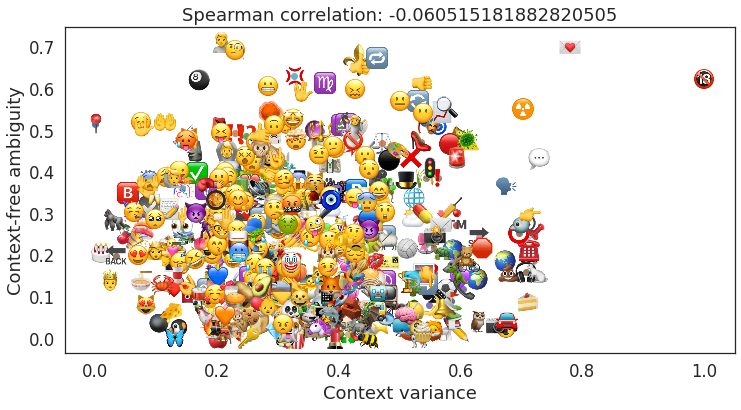

In [43]:
fig, ax = plt.subplots()
for x, y, emoji in zip(measures['context_var'], measures['variation'], measures['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.3, ax=ax, cluster=True)
    ax.scatter(x, y)
ax.set_xlabel("Context variance")
ax.set_ylabel("Context-free ambiguity")
ax.set_title(f"Spearman correlation: {measures[['context_var', 'variation']].corr('spearman').values[0][1]}");

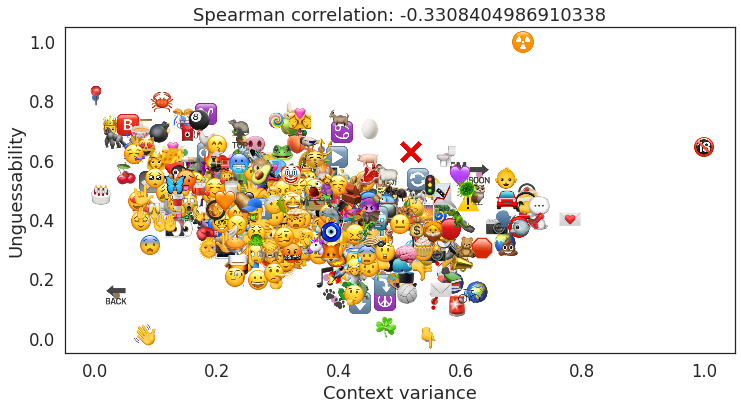

In [44]:
fig, ax = plt.subplots()
for x, y, emoji in zip(measures['context_var'], measures['unguessability'], measures['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.3, ax=ax, cluster=True)
    ax.scatter(x, y)
ax.set_xlabel("Context variance")
ax.set_ylabel("Unguessability")
ax.set_title(f"Spearman correlation: {measures[['context_var', 'unguessability']].corr('spearman').values[0][1]}");

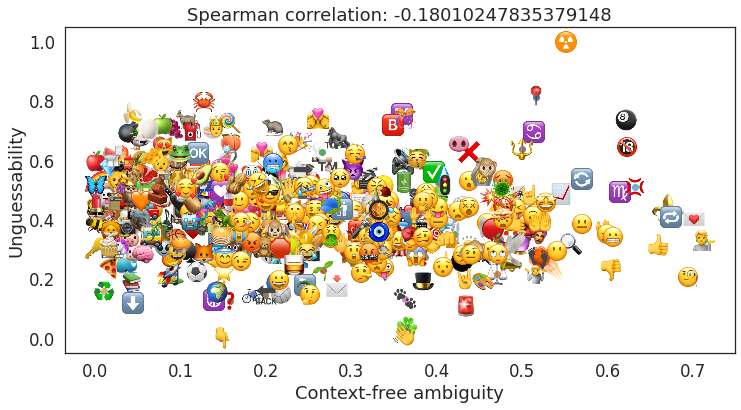

In [45]:
fig, ax = plt.subplots()
for x, y, emoji in zip(measures['variation'], measures['unguessability'], measures['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.3, ax=ax, cluster=True)
    ax.scatter(x, y)
ax.set_xlabel("Context-free ambiguity")
ax.set_ylabel("Unguessability")
ax.set_title(f"Spearman correlation: {measures[['unguessability', 'variation']].corr('spearman').values[0][1]}");

<AxesSubplot:>

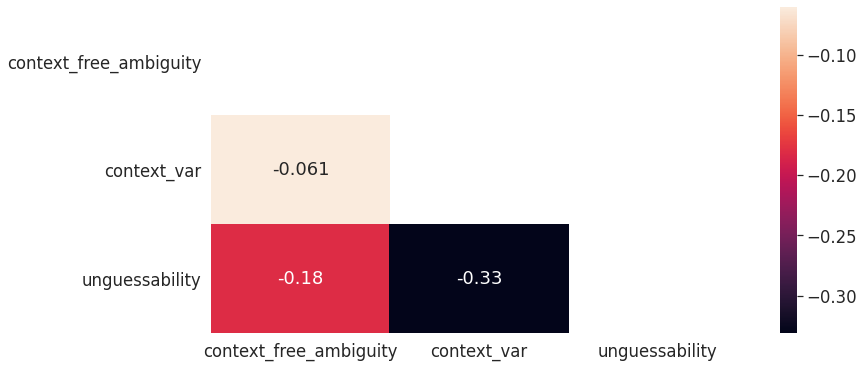

In [46]:
sns.heatmap(measures.rename({"variation": "context_free_ambiguity"}, axis=1).corr('spearman'), annot=True, mask=np.array([[True, True, True], [False, True, True], [False, False, True]]))

In [ ]:
from seaborn_qqplot import pplot

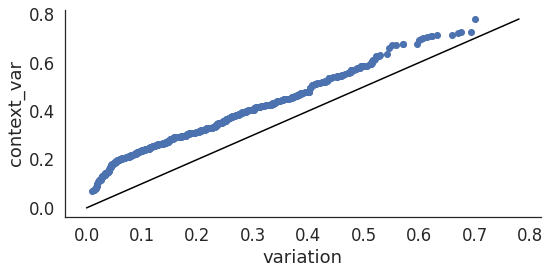

In [60]:
pplot(measures, x="variation", y="context_var", kind='qq',\
      height=4, aspect=2, display_kws={"identity":True});

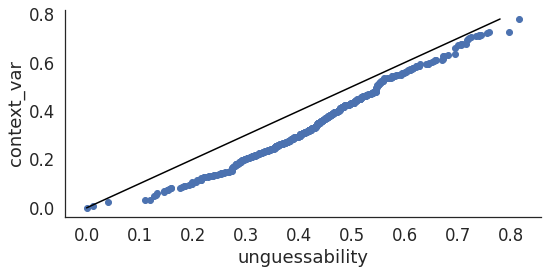

In [61]:
pplot(measures, x="unguessability", y="context_var", kind='qq',\
      height=4, aspect=2, display_kws={"identity":True})

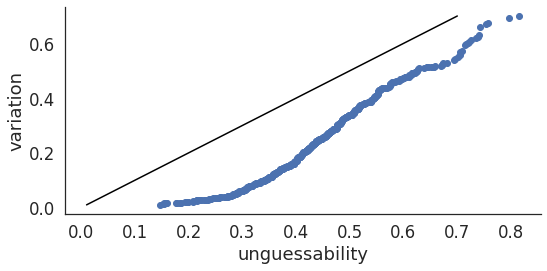

In [62]:
pplot(measures, x="unguessability", y="variation", kind='qq',\
      height=4, aspect=2, display_kws={"identity":True})

In [18]:
import plotly.express as px
# fig = px.scatter_3d(measures, x='unguessability', y='context_var', z='variation',\
#                     color='category', hover_data=['emoji'])
# fig.show()

In [28]:
# import plotly.express as px
# import pandas as pd
# import plotly.graph_objects as go
# import numpy as np


# # fig = px.scatter_3d(df, x='Functionality ', y='Accessibility', z='Immersion', color='Platforms')
# df = measures
# fig = px.scatter_3d(df, x='unguessability', y='context_var', z='variation',\
#                     color='category', hover_data=['emoji'])

# bright_blue = [[0, '#7DF9FF'], [1, '#7DF9FF']]
# bright_pink = [[0, '#FF007F'], [1, '#FF007F']]
# light_yellow = [[0, '#FFDB58'], [1, '#FFDB58']]

# # need to add starting point of 0 to each dimension so the plane extends all the way out
# zero_pt = pd.Series([0])
# z = zero_pt.append(df['variation'], ignore_index=True).reset_index(drop=True)
# y = zero_pt.append(df['context_var'], ignore_index=True).reset_index(drop=True)
# x = zero_pt.append(df['unguessability'], ignore_index=True).reset_index(drop=True)

# length_data = len(z)
# z_plane_pos = 40*np.ones((length_data,length_data))

# fig.add_trace(go.Surface(x=x, y=y, z=z_plane_pos, colorscale=light_yellow,  showscale=False))
# fig.add_trace(go.Surface(x=x.apply(lambda x: 10), y=y, z = np.array([z]*length_data), colorscale= bright_blue, showscale=False))
# fig.add_trace(go.Surface(x=x, y= y.apply(lambda x: 30), z =  np.array([z]*length_data).transpose(), colorscale=bright_pink, showscale=False))
# fig.show()

In [27]:
# save_to_csv(measures, '/scratch/czestoch/emoji-measures/september_all_measures.csv')

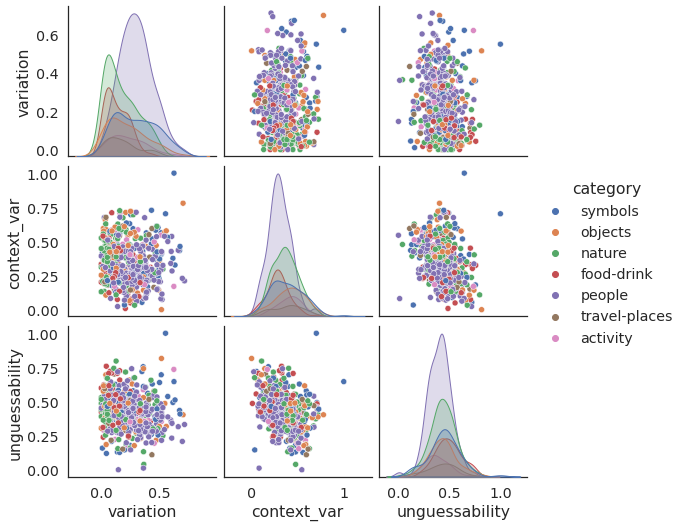

In [23]:
sns.pairplot(measures[measures.category != 'flags'], hue='category')

In [50]:
measures.groupby("category").emoji.count().sort_values()

category
travel-places     23
activity          31
objects           57
food-drink        59
symbols           76
nature           112
people           184
Name: emoji, dtype: int64

<AxesSubplot:xlabel='category', ylabel='variation'>

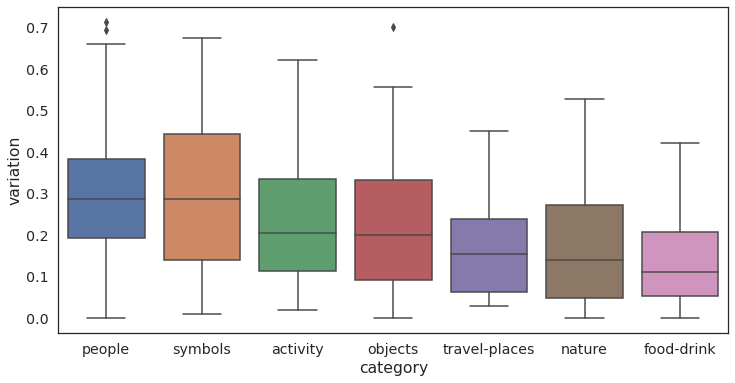

In [45]:
df = measures[["variation", "category"]]
sorted_index = df.groupby("category").median().sort_values("variation", ascending=False).index
sns.boxplot(data=df, x="category", y="variation", order=sorted_index)

<AxesSubplot:xlabel='category', ylabel='context_var'>

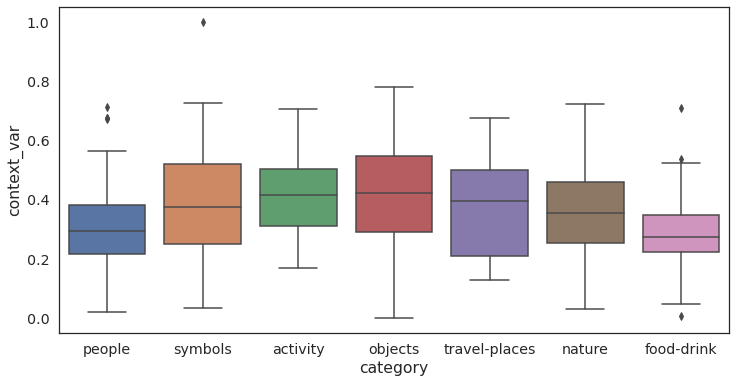

In [46]:
df = measures[["context_var", "category"]]
# sorted_index = df.groupby("category").median().sort_values("context_var", ascending=False).index
sns.boxplot(data=df, x="category", y="context_var", order=sorted_index)

<AxesSubplot:xlabel='category', ylabel='unguessability'>

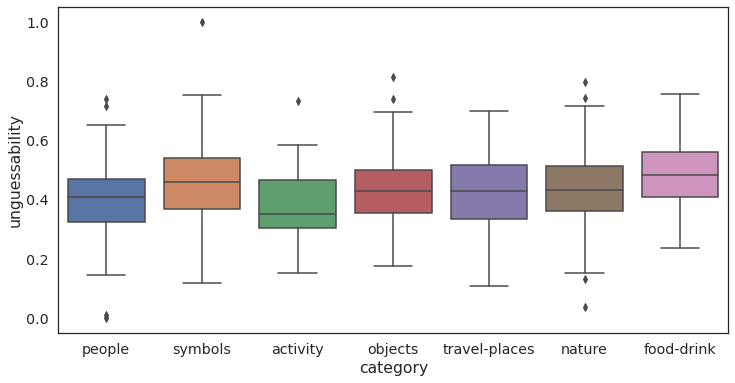

In [47]:
df = measures[["unguessability", "category"]]
# sorted_index = df.groupby("category").median().sort_values("unguessability", ascending=False).index
sns.boxplot(data=df, x="category", y="unguessability", order=sorted_index)

In [57]:
measures

variation emoji  context_var  unguessability category
0     0.276658    ¬©Ô∏è     0.708219        0.491838  symbols
1     0.494922    ‚ÄºÔ∏è     0.228792        0.450096  symbols
2     0.487782    ‚ÅâÔ∏è     0.248033        0.379331  symbols
3     0.272759    ‚Ñ¢Ô∏è     0.593024        0.578358  symbols
4     0.093595     ‚åö     0.265284        0.520986  objects
..         ...   ...          ...             ...      ...
542   0.129710     üß¨     0.424507        0.430411  objects
543   0.073671     üß±     0.421342        0.485465  objects
544   0.197647     üß∏     0.608683        0.306835  objects
545   0.230861     üßπ     0.470045        0.488601  objects
546   0.332203     üßø     0.387189        0.357507  objects

[542 rows x 5 columns]

<AxesSubplot:xlabel='category', ylabel='value'>

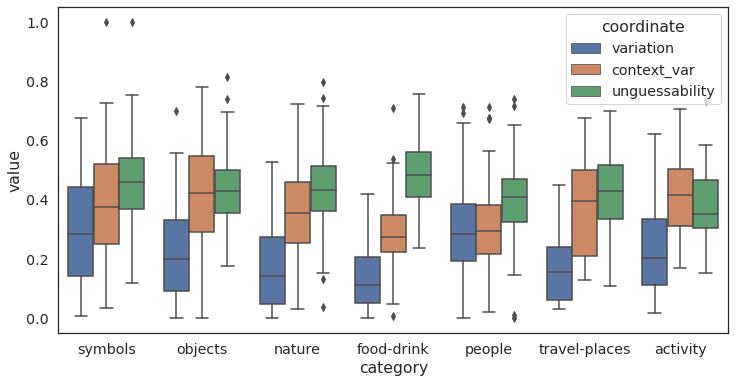

In [61]:
melted = pd.melt(measures, id_vars=['emoji', 'category'], var_name='coordinate', value_name='value')
sns.boxplot(data=melted, x='category', hue='coordinate', y='value')

In [63]:
measures.median()

variation         0.224625
context_var       0.330887
unguessability    0.428358
dtype: float64

In [39]:
variation_median = measures.median().variation
context_var_median = measures.median().context_var
unguessability_median = measures.median().unguessability

first_octant = measures[(measures.variation <= variation_median) & (measures.context_var <= context_var_median)\
                        & (measures.unguessability <= unguessability_median)]

second_octant = measures[(measures.variation <= variation_median) & (measures.context_var <= context_var_median)\
                         & (measures.unguessability > unguessability_median)]

third_octant = measures[(measures.variation <= variation_median) & (measures.context_var > context_var_median)\
                        & (measures.unguessability <= unguessability_median)]

fourth_octant = measures[(measures.variation > variation_median) & (measures.context_var <= context_var_median)\
                         & (measures.unguessability <= unguessability_median)]

fifth_octant = measures[(measures.variation > variation_median) & (measures.context_var > context_var_median)\
                        & (measures.unguessability > unguessability_median)]

sixth_octant = measures[(measures.variation <= variation_median) & (measures.context_var > context_var_median)\
                        & (measures.unguessability > unguessability_median)]

seventh_octant = measures[(measures.variation > variation_median) & (measures.context_var > context_var_median)\
                          & (measures.unguessability <= unguessability_median)]

eigth_octant = measures[(measures.variation > variation_median) & (measures.context_var <= context_var_median)\
                        & (measures.unguessability > unguessability_median)]

octants = [first_octant, second_octant, third_octant, fourth_octant, \
          fifth_octant, sixth_octant, seventh_octant, eigth_octant]

In [45]:
for octant in octants:
    display(octant.category.value_counts())
    display(octant.emoji.values)
    print()

people           11
food-drink        8
nature            6
symbols           4
activity          2
objects           2
travel-places     1
Name: category, dtype: int64

array(['‚òÄÔ∏è', '‚òï', '‚ô•Ô∏è', 'üåÑ', 'üåä', 'üåù', 'üçÜ', 'üçî', 'üçï', 'üç´', 'üçµ', 'üç∑', 'üé≤',
       'üé∂', 'üèÄ', 'üêô', 'üê∂', 'üê∑', 'üëÅÔ∏è', 'üëÉ', 'üëè', 'üíô', 'üîê', 'üîë', 'üîô', 'üòÄ',
       'üòâ', 'üòû', 'üò°', 'üò•', 'üò≠', 'üôÅ', 'üö∂', 'ü•ß'], dtype=object)

nature           24
food-drink       24
people           24
symbols          11
objects           7
activity          2
travel-places     2
Name: category, dtype: int64

array(['‚åö', '‚òî', '‚òπÔ∏è', '‚öæ', '‚õΩ', '‚úä', '‚ù£Ô∏è', '‚ù§Ô∏è', 'üÜó', 'üåõ', 'üåØ', 'üå∑', 'üå∏',
       'üå∫', 'üåº', 'üçá', 'üçå', 'üçç', 'üçé', 'üçè', 'üçë', 'üçú', 'üçû', 'üçü', 'üç¶', 'üç©',
       'üç™', 'üç≠', 'üç∏', 'üç∫', 'üçº', 'üçæ', 'üéÅ', 'üéÇ', 'üéà', 'üêÄ', 'üêà', 'üêå', 'üêç',
       'üêí', 'üêì', 'üêï', 'üê•', 'üêß', 'üêØ', 'üê±', 'üê∏', 'üêª', 'üêº', 'üëÖ', 'üëå', 'üëë',
       'üë´', 'üë∏', 'üëª', 'üëº', 'üíç', 'üíé', 'üíè', 'üíê', 'üíï', 'üíñ', 'üíõ', 'üíû', 'üíü',
       'üí£', 'üí§', 'üîå', 'üî•', 'üñ§', 'üòç', 'üòé', 'üòò', 'üò†', 'üò¥', 'üòª', 'üôÇ', 'üöÇ',
       'üõå', 'ü§†', 'ü§°', 'ü§£', 'ü§¥', 'ü•Å', 'ü•ë', 'ü•î', 'ü•õ', 'ü•§', 'ü•∞', 'ü•∂', 'ü¶Ä',
       'ü¶ã', 'üßÄ', 'üß°'], dtype=object)

nature           26
people           16
symbols          11
objects          11
activity          8
travel-places     7
food-drink        5
Name: category, dtype: int64

array(['‚òÆÔ∏è', '‚ô†Ô∏è', '‚ôªÔ∏è', '‚öΩ', '‚õ≥', '‚úÇÔ∏è', '‚úåÔ∏è', '‚úçÔ∏è', '‚úèÔ∏è', '‚ùì', '‚û°Ô∏è',
       '‚¨ÜÔ∏è', '‚¨áÔ∏è', '‚≠ê', 'üåÖ', 'üåã', 'üåç', 'üåé', 'üåè', 'üåü', 'üå≤', 'üåµ', 'üåπ', 'üåΩ',
       'üçÖ', 'üçø', 'üéÉ', 'üéµ', 'üé∏', 'üéº', 'üèÜ', 'üèåÔ∏è', 'üèê', 'üèí', 'üè°', 'üêá', 'üêé',
       'üêî', 'üêò', 'üêù', 'üê®', 'üê¨', 'üêÆ', 'üê≥', 'üê∫', 'üëÇ', 'üëá', 'üëΩ', 'üíã', 'üíì',
       'üí©', 'üí∞', 'üíª', 'üìñ', 'üìö', 'üìû', 'üì∑', 'üì∫', 'üîí', 'üîî', 'üóΩ', 'üòÜ', 'üòá',
       'üòî', 'üò∫', 'üòø', 'üôâ', 'üöÄ', 'üöå', 'üö≤', 'üõë', 'ü§í', 'ü§ñ', 'ü•û', 'ü¶Å', 'ü¶Ñ',
       'ü¶á', 'ü¶à', 'ü¶ä', 'ü¶é', 'ü¶ñ', 'üßÅ', 'üß†', 'üß∏'], dtype=object)

people           48
nature            9
food-drink        4
symbols           3
activity          2
travel-places     2
objects           1
Name: category, dtype: int64

array(['‚ÅâÔ∏è', '‚òÑÔ∏è', '‚ò†Ô∏è', '‚úàÔ∏è', 'üÜò', 'üåå', 'üåö', 'üåû', 'üåø', 'üçÇ', 'üçù', 'üç¥',
       'üéÑ', 'üéØ', 'üëÄ', 'üëÑ', 'üëä', 'üëã', 'üëê', 'üëì', 'üë∫', 'üíÅ', 'üíÖ', 'üíî', 'üí¶',
       'üí®', 'üíº', 'üì≤', 'üòÅ', 'üòÇ', 'üòÉ', 'üòä', 'üòå', 'üòè', 'üòë', 'üòí', 'üòó', 'üò£',
       'üòß', 'üò®', 'üò´', 'üò¨', 'üò∏', 'üòπ', 'üòº', 'üôÉ', 'üôÑ', 'üôá', 'üôà', 'üôå', 'üôè',
       'ü§ì', 'ü§ó', 'ü§ò', 'ü§ô', 'ü§ö', 'ü§ù', 'ü§û', 'ü§•', 'ü§ß', 'ü§¨', 'ü§Æ', 'ü§Ø', 'ü§≤',
       'ü•Ç', 'ü•É', 'ü•ä', 'ü•¥', 'üßê'], dtype=object)

symbols          15
people           13
nature            7
objects           4
travel-places     3
food-drink        2
Name: category, dtype: int64

array(['¬©Ô∏è', '‚Ñ¢Ô∏è', '‚ò¢Ô∏è', '‚ôã', '‚ôç', '‚öì', '‚öúÔ∏è', '‚ö†Ô∏è', '‚ö°', '‚õÖ', '‚ùå', 'üåï',
       'üçó', 'üç≥', 'üé•', 'üêë', 'üëÜ', 'üëâ', 'üëü', 'üë©\u200d‚ù§Ô∏è\u200düíã\u200düë©', 'üíÄ',
       'üí•', 'üí¨', 'üí¥', 'üìà', 'üîÑ', 'üîú', 'üîû', 'üî´', 'üî±', 'üîµ', 'üòà', 'üòö', 'üò¢',
       'üò§', 'üòÆ', 'üòΩ', 'üòæ', 'üö¶', 'üö´', 'ü§™', 'ü•Ä', 'ü¶†', 'üßπ'], dtype=object)

nature           19
food-drink       10
objects          10
people            6
activity          5
travel-places     5
symbols           4
Name: category, dtype: int64

array(['‚ñ∂Ô∏è', '‚òéÔ∏è', '‚ö∞Ô∏è', 'üåÉ', 'üåà', 'üåô', 'üå†', 'üåÆ', 'üå≥', 'üåª', 'üçÑ', 'üçâ', 'üçä',
       'üçã', 'üçì', 'üçØ', 'üç∞', 'üéí', 'üé£', 'üéß', 'üé´', 'üèÉ', 'üèÖ', 'üèà', 'üè†', 'üêÑ',
       'üêÖ', 'üêê', 'üêñ', 'üêú', 'üêü', 'üê¢', 'üê£', 'üê∞', 'üê¥', 'üëß', 'üë∂', 'üíÑ', 'üíó',
       'üíö', 'üíú', 'üíµ', 'üí∏', 'üì±', 'üìª', 'üî®', 'üî™', 'üöó', 'üöò', 'üöΩ', 'ü§∞', 'ü•ö',
       'ü•ú', 'ü•©', 'ü¶Ö', 'ü¶Ü', 'ü¶â', 'üß¨', 'üß±'], dtype=object)

people           33
objects          14
symbols          13
nature           13
activity          9
travel-places     1
food-drink        1
Name: category, dtype: int64

array(['‚è∞', '‚òÅÔ∏è', '‚òòÔ∏è', '‚ò∫Ô∏è', '‚ôé', '‚öîÔ∏è', '‚öñÔ∏è', '‚ö´', '‚úùÔ∏è', '‚ú®', '‚ùó', '‚§µÔ∏è',
       '‚≠ï', 'üÖøÔ∏è', 'üåÄ', 'üåê', 'üå±', 'üåæ', 'üçÅ', 'üçÉ', 'üçπ', 'üéÄ', 'üéì', 'üé§', 'üé®',
       'üé©', 'üé™', 'üé≠', 'üéæ', 'üèâ', 'üèè', 'üèπ', 'üêä', 'üê¶', 'üêæ', 'üëà', 'üëç', 'üëé',
       'üë†', 'üë£', 'üëπ', 'üëæ', 'üíä', 'üíå', 'üí°', 'üí´', 'üí≠', 'üìå', 'üì¢', 'üì£', 'üì¶',
       'üì©', 'üì∏', 'üîÅ', 'üîç', 'üîÆ', 'üî¥', 'üïäÔ∏è', 'üñï', 'üññ', 'üó£Ô∏è', 'üòÑ', 'üòÖ', 'üòê',
       'üòï', 'üòñ', 'üòú', 'üòü', 'üòØ', 'üò∞', 'üò±', 'üò≤', 'üò≥', 'üò∂', 'üö®', 'ü§ê', 'ü§î',
       'ü§ú', 'ü§¶', 'ü§®', 'ü§´', 'ü§∑', 'ü•á', 'üßø'], dtype=object)

people           33
symbols          15
objects           8
nature            8
food-drink        5
activity          3
travel-places     2
Name: category, dtype: int64

array(['‚ÄºÔ∏è', '‚è≥', '‚òëÔ∏è', '‚òùÔ∏è', '‚ôà', '‚úÖ', '‚úã', '‚úîÔ∏è', '‚ùÑÔ∏è', '‚ùï', 'üÉè', 'üÖ±Ô∏è',
       'üå¥', 'üçÄ', 'üçí', 'üç£', 'üç¨', 'üçª', 'üéâ', 'üéä', 'üé¨', 'üéÆ', 'üé±', 'üêâ', 'üêΩ',
       'üëø', 'üíÉ', 'üíÜ', 'üíâ', 'üíò', 'üíù', 'üí¢', 'üíß', 'üí™', 'üíØ', 'üìç', 'üìù', 'üîä',
       'üîã', 'üîù', 'üï∫', 'üñêÔ∏è', 'üóø', 'üòã', 'üòì', 'üòô', 'üòõ', 'üòù', 'üò¶', 'üò©', 'üò™',
       'üòµ', 'üò∑', 'üôÄ', 'üôÖ', 'üôÜ', 'üôä', 'üôã', 'üö¨', 'üöÆ', 'üõ´', 'ü§ë', 'ü§ï', 'ü§ü',
       'ü§¢', 'ü§§', 'ü§©', 'ü§≠', 'ü•ò', 'ü•≥', 'ü•µ', 'ü•∫', 'ü¶ç', 'üß¢'], dtype=object)